**Goal: Goal of this task is to create an end-to-end ML pipeline that could accurately detect CYBER BULLYING.**

**A large chunk of textual data would be used with labels on it, 1 telling it's an agressive text and 0 telling it's not an agressive data.**

**The output could be used in identifying CYBER BULLYING and can be used by Forensics, Police, Cyber Security, Lawyers, Social Media.**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#users_data.csv #https://drive.google.com/file/d/1IiM9EXSlKIjTJmU-TXHQtYLhoVnMySwr/view?usp=drive_link
#peerness_values.csv #https://drive.google.com/file/d/1aFQ5yAVKKDg7E8OYphbR3lLjrke4ndaK/view?usp=drive_link
#Aggressive_All.csv #https://drive.google.com/file/d/1Jg-F89PrL8WhQFoYbWJQjm5zvgqGiKiz/view?usp=drive_link
#Non_Aggressive_All.csv #https://drive.google.com/file/d/1D_76NaFYmi08PvjvS-LdfBkl1YsBeXXO/view?usp=drive_link

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Loading**

In [4]:
users_data = pd.read_csv("/content/drive/MyDrive/Hackathon Guys/1. users_data.csv")
peerness_values =pd.read_csv("/content/drive/MyDrive/Hackathon Guys/2. peerness_values.csv")
aggressive_all = pd.read_csv("/content/drive/MyDrive/Hackathon Guys/3. Aggressive_All.csv")
non_aggressive_all = pd.read_csv("/content/drive/MyDrive/Hackathon Guys/4. Non_Aggressive_All.csv")
communication_data =pd.read_csv("/content/drive/MyDrive/Hackathon Guys/5. Communication_Data_Among_Users.csv")
cb_labels =pd.read_csv("/content/drive/MyDrive/Hackathon Guys/6. CB_Labels.csv")

In [5]:
print(users_data.head(3))

   UserID  Age  Gender School Name  Grade
0       1   11  Others    School10      5
1       2   15    Male     School5      9
2       3   11    Male    School13      5


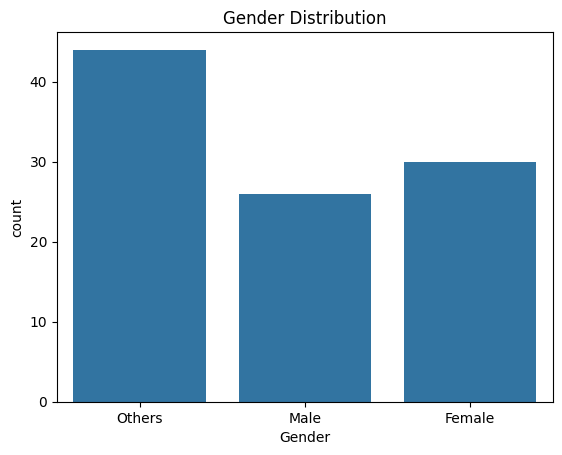

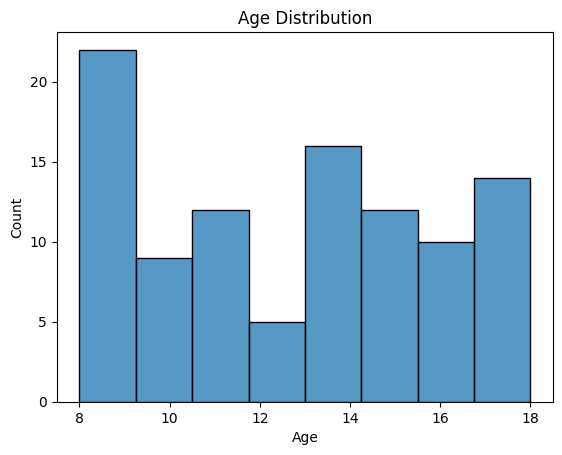

In [6]:
# Users Data Analysis

sns.countplot(data=users_data, x="Gender")
plt.title("Gender Distribution")
plt.show()

sns.histplot(data=users_data, x="Age")
plt.title("Age Distribution")
plt.show()

3 Genders: Male, Female and Others

Age distribution is spread in the range of 8 years to 18 years

In [7]:
peerness_values.head(2)

,User 1,User 2,Peerness
0,1,2,0.500000
1,1,3,0.766667


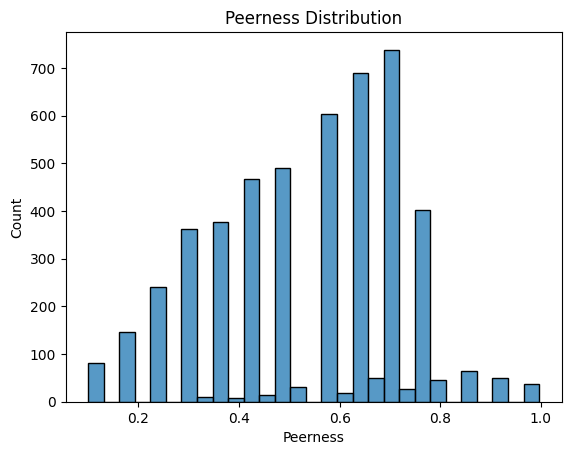

In [8]:
#Peerness Values Analysis
#print("\nPeerness Values Overview")
#print(peerness_values.info())
#print(peerness_values.describe())
sns.histplot(data=peerness_values, x="Peerness")
plt.title("Peerness Distribution")
plt.show()

In [9]:
aggressive_all.head(10)

,No.,Message
0,1,zhha Islam does nothing but freeze the status ...
1,2,You dont get out much do you
2,3,MaxBlumenthal Campagnebds Blumenthal self prom...
3,4,No silly it isnt ITS UR MOMS and might I say q...
4,5,Yes there is even more rape in Muslim countrie...
5,6,I think that you are so sexy and hot and sexy ...
6,7,hey shithead quit fucking with all the ufc p...
7,8,WOW you suck cock You upset me so much with yo...
8,9,Hahaha you dont actually believe this bullshit...
9,10,czechofile is worse than a pedophile czechof...


In [10]:
non_aggressive_all.head(2)

,No.,Message
0,1,Libya casualty report French operations You ...
1,2,Just for the record that IP is blocked for ho...


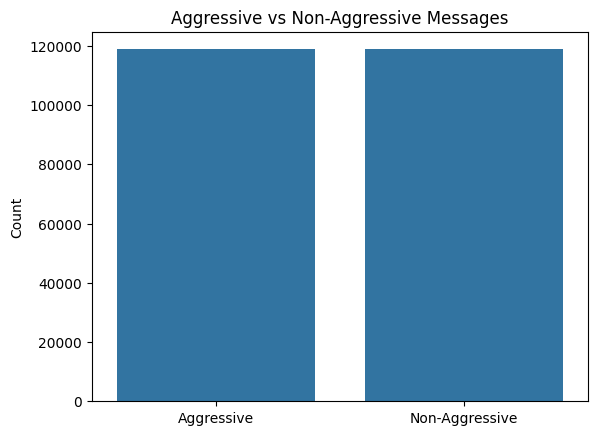

In [11]:
#Aggressive and Non-Aggressive Messages
#print("\nAggressive Messages Count:", aggressive_all.shape[0])
#print("Non-Aggressive Messages Count:", non_aggressive_all.shape[0])
sns.barplot(x=["Aggressive", "Non-Aggressive"], y=[aggressive_all.shape[0], non_aggressive_all.shape[0]])
plt.title("Aggressive vs Non-Aggressive Messages")
plt.ylabel("Count")
plt.show()

In [12]:
communication_data.head(2)

,Date,Time,User1 ID,User2 ID,Message,Label
0,2021-03-04,10:17,1,2,bye bye dear bajaj i got some better work to ...,1
1,2022-01-24,04:27,1,2,Haha your so funny you sit on wikipedia all da...,1


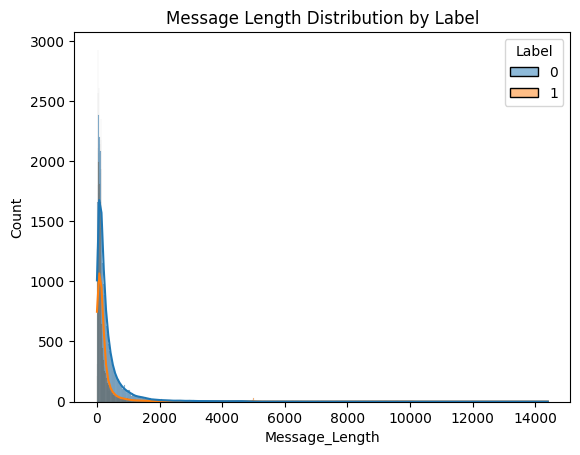

In [13]:
# Aggregate message lengths
communication_data["Message_Length"] = communication_data["Message"].str.len()
sns.histplot(data=communication_data, x="Message_Length", hue="Label",kde = True)
plt.title("Message Length Distribution by Label")
plt.show()


Communication Data Overview


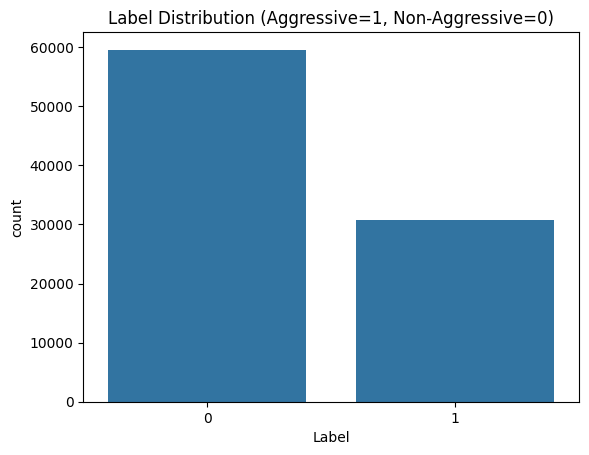

In [14]:
# Communication Data Analysis
print("\nCommunication Data Overview")
#print(communication_data.info())
#print(communication_data["Label"].value_counts())
sns.countplot(data=communication_data, x="Label")
plt.title("Label Distribution (Aggressive=1, Non-Aggressive=0)")
plt.show()

In [15]:
cb_labels.head(2)

,User1 ID,User2 ID,Total_messages,Aggressive_Count,Intent_to_Harm,Peerness,CB_Label
0,1,2,36,23,0.769444,0.500000,1
1,1,3,16,9,0.481250,0.766667,1


In [16]:
#Checking NULL Values in the Data Set
print("NULL values in users_data",users_data.isnull().sum())
print()
print("NULL values in peerness_values",peerness_values.isnull().sum())
print()
print("NULL values in aggressive_all",aggressive_all.isnull().sum())
print()
print("NULL values in non_aggressive_all",non_aggressive_all.isnull().sum())
print()
print("NULL values in communication_data",communication_data.isnull().sum())
print()
print("NULL values in cb_labels",cb_labels.isnull().sum())

NULL values in users_data UserID         0
Age            0
Gender         0
School Name    0
Grade          0
dtype: int64

NULL values in peerness_values User 1      0
User 2      0
Peerness    0
dtype: int64

NULL values in aggressive_all No.         0
Message    21
dtype: int64

NULL values in non_aggressive_all No.         0
Message    50
dtype: int64

NULL values in communication_data Date              0
Time              0
User1 ID          0
User2 ID          0
Message           0
Label             0
Message_Length    0
dtype: int64

NULL values in cb_labels User1 ID               0
User2 ID               0
Total_messages         0
Aggressive_Count       0
Intent_to_Harm         0
Peerness            4686
CB_Label               0
dtype: int64


In [17]:
#Checking Shape of the Data Set
print("Shape users_data",users_data.shape)
print()
print("Shape peerness_values",peerness_values.shape)
print()
print("Shape aggressive_all",aggressive_all.shape)
print()
print("Shape non_aggressive_all",non_aggressive_all.shape)
print()
print("Shape communication_data",communication_data.shape)
print()
print("Shape cb_labels",cb_labels.shape)

Shape users_data (100, 5)

Shape peerness_values (4950, 3)

Shape aggressive_all (118828, 2)

Shape non_aggressive_all (118828, 2)

Shape communication_data (90356, 7)

Shape cb_labels (9511, 7)


In [18]:
cb_labels.shape

(9511, 7)

In [19]:
communication = communication_data.merge(peerness_values, how="left", left_on=["User1 ID", "User2 ID"], right_on=["User 1", "User 2"]).drop(columns=["User 1","User 2"])

In [20]:
communication.head(5)

,Date,Time,User1 ID,User2 ID,Message,Label,Message_Length,Peerness
0,2021-03-04,10:17,1,2,bye bye dear bajaj i got some better work to ...,1,83,0.5
1,2022-01-24,04:27,1,2,Haha your so funny you sit on wikipedia all da...,1,98,0.5
2,2021-02-03,02:19,1,2,My problem is people talking out of their asse...,1,187,0.5
3,2021-09-04,08:54,1,2,Article updated,0,15,0.5
4,2021-07-21,13:15,1,2,Well arent you phucking special Its easy to ha...,1,119,0.5


In [21]:
communication['Peerness'].value_counts().sort_values(ascending = True)

,count
Peerness,
0.330000,72
0.796667,96
0.396667,109
0.730000,139
0.730000,157
0.463333,209
0.596667,263
0.530000,317
0.996667,367


In [22]:
communication.shape

(90356, 8)

In [23]:
communication1 = communication.merge(users_data, how="left", left_on="User1 ID", right_on="UserID").rename(
    columns={"Age": "Age_User1", "Gender": "Gender_User1", "Grade": "Grade_User1"}
).drop(columns=["UserID"])

# Merge to get details for User2
communication2 = communication1.merge(users_data, how="left", left_on="User2 ID", right_on="UserID").rename(
    columns={"Age": "Age_User2", "Gender": "Gender_User2", "Grade": "Grade_User2"}
).drop(columns=["UserID"])

communication2.head(2)

,Date,Time,User1 ID,User2 ID,Message,Label,Message_Length,Peerness,Age_User1,Gender_User1,School Name_x,Grade_User1,Age_User2,Gender_User2,School Name_y,Grade_User2
0,2021-03-04,10:17,1,2,bye bye dear bajaj i got some better work to ...,1,83,0.5,11,Others,School10,5,15,Male,School5,9
1,2022-01-24,04:27,1,2,Haha your so funny you sit on wikipedia all da...,1,98,0.5,11,Others,School10,5,15,Male,School5,9


In [24]:
communication2.to_csv("final-DATA.csv")

In [25]:
comms = pd.read_csv("/content/drive/MyDrive/Hackathon Guys/comms_f.csv")
comms.drop(columns=["Unnamed: 0"], errors='ignore',inplace=True)
comms.head(2)

,User1 ID,User2 ID,Message,Label,Peerness,Age_User1,Gender_User1,Grade_User1,Age_User2,Gender_User2,Grade_User2
0,1,2,bye bye dear bajaj i got some better work to ...,1,0.5,11,Others,5,15,Male,9
1,1,2,Haha your so funny you sit on wikipedia all da...,1,0.5,11,Others,5,15,Male,9


In [26]:
comms.shape

(90356, 11)

In [27]:
comms.head()

,User1 ID,User2 ID,Message,Label,Peerness,Age_User1,Gender_User1,Grade_User1,Age_User2,Gender_User2,Grade_User2
0,1,2,bye bye dear bajaj i got some better work to ...,1,0.5,11,Others,5,15,Male,9
1,1,2,Haha your so funny you sit on wikipedia all da...,1,0.5,11,Others,5,15,Male,9
2,1,2,My problem is people talking out of their asse...,1,0.5,11,Others,5,15,Male,9
3,1,2,Article updated,0,0.5,11,Others,5,15,Male,9
4,1,2,Well arent you phucking special Its easy to ha...,1,0.5,11,Others,5,15,Male,9


In [28]:
comms.isnull().sum()

,0
User1 ID,0
User2 ID,0
Message,0
Label,0
Peerness,33748
Age_User1,0
Gender_User1,0
Grade_User1,0
Age_User2,0
Gender_User2,0


In [29]:
#filling the null values
# KNN Imputation for 'Peerness'
imputer_knn = KNNImputer(n_neighbors=5)
comms['Peerness'] = imputer_knn.fit_transform(comms[['Peerness', 'Age_User1', 'Grade_User1', 'Age_User2', 'Grade_User2']])[:, 0]

# Linear Interpolation for Demographic Features
comms['Age_User1'] = comms['Age_User1'].interpolate(method='linear')
comms['Grade_User1'] = comms['Grade_User1'].interpolate(method='linear')
comms['Age_User2'] = comms['Age_User2'].interpolate(method='linear')
comms['Grade_User2'] = comms['Grade_User2'].interpolate(method='linear')

# For Gender columns, fill missing with the most frequent value (mode)
comms['Gender_User1'] = comms['Gender_User1'].fillna(comms['Gender_User1'].mode()[0])
comms['Gender_User2'] = comms['Gender_User2'].fillna(comms['Gender_User2'].mode()[0])
comms['Label'] = comms['Label'].fillna(comms['Label'].mode()[0])

In [30]:
comms.isnull().sum()

,0
User1 ID,0
User2 ID,0
Message,0
Label,0
Peerness,0
Age_User1,0
Gender_User1,0
Grade_User1,0
Age_User2,0
Gender_User2,0


In [31]:
# Encode categorical data (e.g., gender)
label_encoder = LabelEncoder()
comms['Gender_User1'] = label_encoder.fit_transform(comms['Gender_User1'])
comms['Gender_User2'] = label_encoder.fit_transform(comms['Gender_User2'])

In [32]:
comms.head(5)

,User1 ID,User2 ID,Message,Label,Peerness,Age_User1,Gender_User1,Grade_User1,Age_User2,Gender_User2,Grade_User2
0,1,2,bye bye dear bajaj i got some better work to ...,1,0.5,11,2,5,15,1,9
1,1,2,Haha your so funny you sit on wikipedia all da...,1,0.5,11,2,5,15,1,9
2,1,2,My problem is people talking out of their asse...,1,0.5,11,2,5,15,1,9
3,1,2,Article updated,0,0.5,11,2,5,15,1,9
4,1,2,Well arent you phucking special Its easy to ha...,1,0.5,11,2,5,15,1,9


In [33]:
comms['Gender_User1'].value_counts()

,count
Gender_User1,
2,35593
1,28746
0,26017


In [34]:
comms['Age_User1'].value_counts()

,count
Age_User1,
8,10639
16,10474
11,9999
15,9858
17,8644
10,8474
13,8141
9,7021
18,6126


In [35]:
comms['Age_User2'].value_counts()

,count
Age_User2,
8,12036
11,10805
15,10747
13,9112
16,8873
9,8175
10,8098
17,6564
18,6227


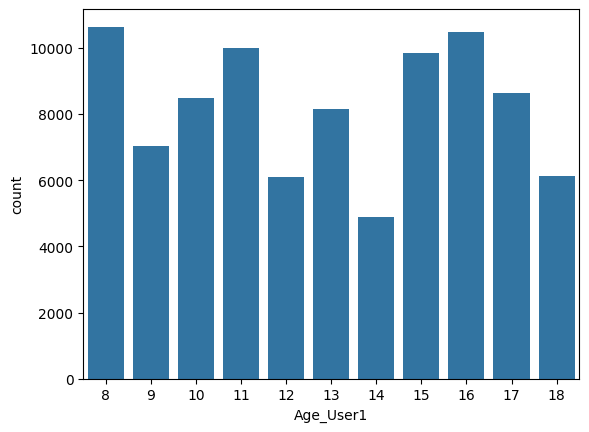

In [36]:
#plot a bar chart of Age_User1 and Age_User2 value count
sns.countplot(x=comms['Age_User1'])
plt.show()

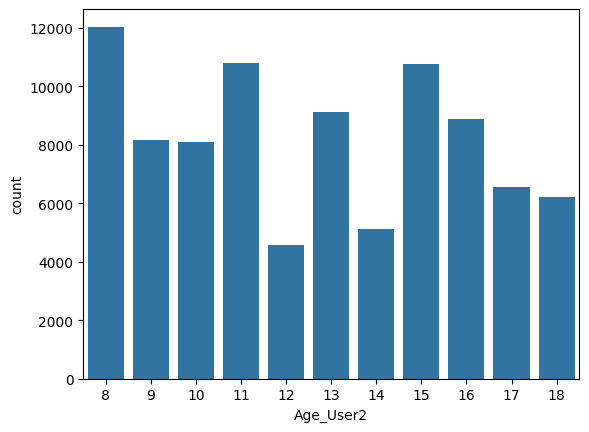

In [37]:
#plot a bar chart of Age_User1 and Age_User2 value count
sns.countplot(x=comms['Age_User2'])
plt.show()

**From here onwards, the code was run on Institute's Super Computer.**

In [ ]:
#Prepare the features (X) and target (y)
X_text = comms['Message']
X_other = comms[['Peerness', 'Age_User1', 'Gender_User1', 'Grade_User1', 'Age_User2', 'Gender_User2', 'Grade_User2']]
y = comms['Label']

# Load a more advanced Sentence Transformer model
model = SentenceTransformer('all-mpnet-base-v2')

# Generate embeddings using Sentence Transformers
X_bert = model.encode(X_text.tolist(), batch_size=32, show_progress_bar=True)

# Combine Sentence Transformer embeddings with other features
X_other = X_other.values  # Already in NumPy
X = np.concatenate((X_bert, X_other), axis=1)  # Convert combined features to NumPy

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2824 [00:00<?, ?it/s]

KeyboardInterrupt: 